# Импорт библиотек

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

from scipy.sparse import hstack, csr_matrix

from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Обработка датасета

In [ ]:
df1_alb = pd.read_csv("/content/drive/MyDrive/RecSys_Alb/spotify_albums.csv")
df1_lyrics = pd.read_csv("/content/drive/MyDrive/RecSys_Alb/tracks_with_lyrics.csv")


df2_alb=pd.read_csv("/content/drive/MyDrive/RecSys_Alb/spotify_albums1.csv")
df2_lyrics=pd.read_csv("/content/drive/MyDrive/RecSys_Alb/tracks_with_lyrics1.csv")

In [ ]:
data = pd.concat([df1_alb, df2_alb])
data = data.drop_duplicates(subset=['album_id'], keep='last')

In [ ]:
data_lyrics= pd.concat([df1_lyrics, df2_lyrics])
data_lyrics = data_lyrics.dropna(subset=['lyrics'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 142
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   album_id            294 non-null    object 
 1   album_name          294 non-null    object 
 2   artist_name         294 non-null    object 
 3   genres              294 non-null    object 
 4   release_date        294 non-null    object 
 5   total_duration_min  294 non-null    float64
 6   total_tracks        294 non-null    int64  
 7   artist_popularity   294 non-null    int64  
 8   album_popularity    294 non-null    int64  
 9   album_type          294 non-null    object 
 10  featured_artists    29 non-null     object 
 11  artist_followers    294 non-null    int64  
 12  label               294 non-null    object 
dtypes: float64(1), int64(4), object(8)
memory usage: 32.2+ KB


In [ ]:
data_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3394 entries, 0 to 1942
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   album_id          3394 non-null   object
 1   track_name        3394 non-null   object
 2   album_name        3394 non-null   object
 3   artist_name       3394 non-null   object
 4   featured_artists  909 non-null    object
 5   track_number      3394 non-null   int64 
 6   duration_ms       3394 non-null   int64 
 7   explicit          3394 non-null   bool  
 8   popularity        3394 non-null   int64 
 9   lyrics            3394 non-null   object
 10  has_lyrics        3394 non-null   bool  
dtypes: bool(2), int64(3), object(6)
memory usage: 271.8+ KB


# датасет полностью обработанный

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/RecSys_Alb/data.csv")

In [ ]:
data=data.drop(["Unnamed: 0", "text_features"], axis=1)
data=data.fillna(0)

In [ ]:
data

,album_id,album_name,artist_name,genres,release_date,total_duration_min,total_tracks,artist_popularity,album_popularity,album_type,featured_artists,artist_followers,label,avg_sentiment,sentiment
0,34wROmgt59d9sUGarSIUkk,God Save The Rave,Scooter,"happy hardcore, eurodance",2021-04-16,52.38,15,69,58,album,0,925943,Sheffield Tunes,0.196589,neutral
1,3bfgBQwwP00KPKz6QmsNYz,Regimental Sgt. Zippo,Elton John,Unknown,2022-07-08,39.62,12,84,34,album,0,14796232,UMC (Universal Music Catalogue),0.000000,neutral
2,0VZo00CZ7kv8GH7fUzSqTr,Experience,Ludovico Einaudi,"neoclassical, classical",2024-09-21,52.15,10,80,55,album,0,3808329,UME - Global Clearing House,0.000000,neutral
3,6bETdAF0lCZyR17QfPfkYr,Selfhelpingmehelpmyself,Sam Vano,indie folk,2025-04-18,37.09,11,28,34,album,0,456,Sam Vano,0.000000,neutral
4,73xmQcgQYxMRXsL2aLE6I7,SDL 1,Ronnie Flex,nederpop,2025-03-20,50.98,19,70,57,album,0,604513,ADF ENT,-0.908940,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2kAer61g2HN6upL2zXAjzd,MTV Unplugged (Live),Twenty One Pilots,Unknown,2023-04-21,34.39,7,85,49,album,0,25340725,Fueled By Ramen,-0.213987,negative
290,3rlJCPz7s7bTifG57wjFpt,LEGENDADDY,Daddy Yankee,"reggaeton, latin",2022-03-25,54.51,19,88,68,album,0,37040841,Republic Records,-0.821857,negative
291,52pl5ANwTRORPcPj6vlzA8,The Diary Of Alicia Keys 20,Alicia Keys,"r&b, neo soul",2023-12-01,103.06,24,80,47,album,0,12561359,J Records/Legacy,0.027279,neutral
292,4B1OcSXS2KrWUlGjV0yPbq,QUAZIMODO,kizaru,Unknown,2024-07-19,36.76,17,65,46,album,0,1472879,HAUNTED FAMILY,-0.765799,negative


# Работа с текстом песен

In [ ]:

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

def clean_lyrics(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_sentiment(text, analyzer, batch_size=32):

    if not text.strip():
        return 0.0

    try:

        max_length = 512 - 2
        text_parts = [text[i:i+max_length] for i in range(0, len(text), max_length)]

        results = []
        for i in range(0, len(text_parts), batch_size):
            batch = text_parts[i:i+batch_size]
            batch_results = analyzer(batch)
            results.extend(batch_results)


        positive_scores = [result['score'] if result['label'] == 'POSITIVE' else 1 - result['score']
                          for result in results]
        avg_score = sum(positive_scores) / len(positive_scores) if positive_scores else 0.5
        return avg_score * 2 - 1
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.0


data_lyrics['cleaned_lyrics'] = data_lyrics['lyrics'].apply(clean_lyrics)


batch_size = 16
texts = data_lyrics['cleaned_lyrics'].tolist()
sentiment_scores = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    batch_scores = [get_sentiment(text, sentiment_analyzer) for text in batch]
    sentiment_scores.extend(batch_scores)

data_lyrics['sentiment_score'] = sentiment_scores




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
mean_sentiment = data_lyrics.groupby('album_id')['sentiment_score'].mean().reset_index()
mean_sentiment.rename(columns={'sentiment_score': 'avg_sentiment'}, inplace=True)

data = pd.merge(
    data,
    mean_sentiment,
    on='album_id',
    how='left'
)


In [ ]:
def classify_sentiment(score):
    if score > 0.2:
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['avg_sentiment'].apply(classify_sentiment)
data.info()

# Анализ датасета

In [ ]:
data.tail(4)

,album_id,album_name,artist_name,genres,release_date,total_duration_min,total_tracks,artist_popularity,album_popularity,album_type,featured_artists,artist_followers,label,avg_sentiment,sentiment
290,3rlJCPz7s7bTifG57wjFpt,LEGENDADDY,Daddy Yankee,"reggaeton, latin",2022-03-25,54.51,19,88,68,album,0,37040841,Republic Records,-0.821857,negative
291,52pl5ANwTRORPcPj6vlzA8,The Diary Of Alicia Keys 20,Alicia Keys,"r&b, neo soul",2023-12-01,103.06,24,80,47,album,0,12561359,J Records/Legacy,0.027279,neutral
292,4B1OcSXS2KrWUlGjV0yPbq,QUAZIMODO,kizaru,Unknown,2024-07-19,36.76,17,65,46,album,0,1472879,HAUNTED FAMILY,-0.765799,negative
293,2sU8ByeYc5BOBFNDr58CGV,For Broken Ears,Tems,"afrobeats, alté, afrobeat",2020-09-25,20.71,7,77,71,album,0,3103089,Leading Vibe Ltd,0.015455,neutral


In [ ]:
print(len(pd.unique(data["artist_name"])))
data.value_counts("artist_name")

194


,count
artist_name,
Adele,2
Alicia Keys,2
Crystal Castles,2
Anitta,2
Andre Hazes,2
...,...
Zara Larsson,1
kizaru,1
d4vd,1


In [ ]:
print(len(pd.unique(data["genres"])))
data.value_counts("genres")

101


,count
genres,
Unknown,94
nederpop,24
soft pop,7
tropical house,6
r&b,4
...,...
slowcore,1
"soul, motown, soul blues",1
synthpop,1


In [ ]:
print(len(pd.unique(data["label"])))
data.value_counts("label")

178


,count
label,
Columbia,11
Atlantic Records,8
UMC (Universal Music Catalogue),8
"Universal Music, a division of Universal International Music BV",6
Reprise,5
...,...
Vertigo Berlin,1
Warner Music Benelux,1
Warner Music Central Europe,1


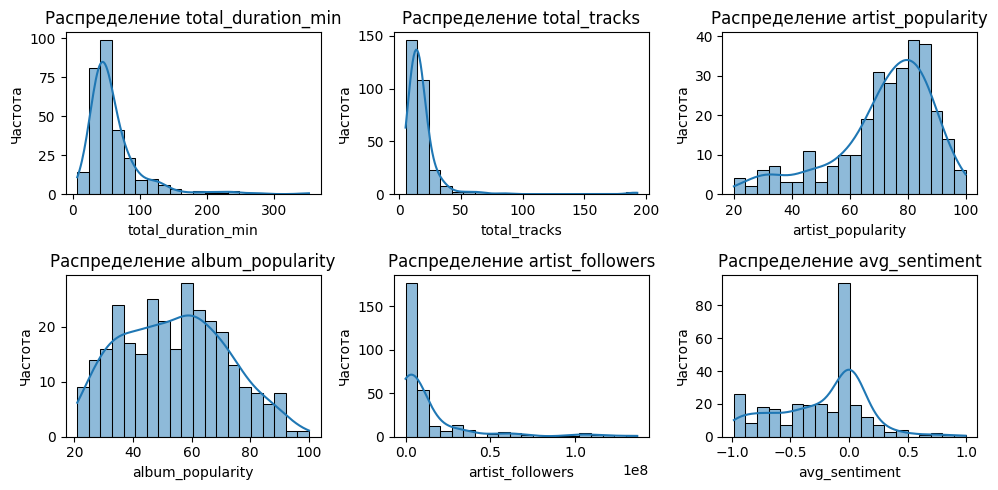

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


numeric_columns = [
    'total_duration_min',
    'total_tracks',
    'artist_popularity',
    'album_popularity',
    'artist_followers',
    'avg_sentiment'
]

plt.figure(figsize=(10, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()


# Метод на основе cosine_similarity

Средняя диверсификация (по artist_name): 0.3945

Средняя диверсификация (по sentiment): 0.3401

Средняя диверсификация (по label): 0.5408

Среднее сходство: 0.4762




In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def prepare_features_for_cosine_sim(data):
    data['featured_artists'] = data['featured_artists'].fillna('').astype(str)

    numeric_cols = ['total_duration_min', 'total_tracks', 'artist_popularity',
                    'album_popularity', 'artist_followers', 'avg_sentiment']

    scaler = MinMaxScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    data['combined_features'] = (
        data['artist_name'] + ' ' +
        data['genres'] + ' ' +
        data['album_type'] + ' ' +
        data['featured_artists'] + ' ' +
        data['label'] + ' ' +
        data['total_duration_min'].astype(str) + ' ' +
        data['total_tracks'].astype(str) + ' ' +
        data['artist_popularity'].astype(str) + ' ' +
        data['album_popularity'].astype(str) + ' ' +
        data['artist_followers'].astype(str) + ' ' +
        data['avg_sentiment'].astype(str) + ' ' +
        data['sentiment']
    )
    return data

def get_recommendations_for_cosine_sim(input_albums_with_ratings, data, n_recommendations=5):
    data = prepare_features_for_cosine_sim(data.copy())

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(data['combined_features'])

    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    input_indices = []
    input_weights = []

    for album_name, rating in input_albums_with_ratings:
        matches = data[data['album_name'].str.contains(album_name, case=False, na=False, regex=False)].index
        if len(matches) > 0:
            for idx in matches:
                input_indices.append(idx)
                input_weights.append(rating)

    if not input_indices:
        return "Ни один из альбомов не найден в базе данных."

    input_weights = [w / 10 for w in input_weights]


    weighted_sims = sum(weight * cosine_sim[i] for i, weight in zip(input_indices, input_weights))
    avg_sim_scores = weighted_sims / sum(input_weights)

    sim_scores = list(enumerate(avg_sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    seen_albums = set(data['album_name'].iloc[input_indices])

    for i, score in sim_scores:
        if len(recommendations) >= n_recommendations:
            break
        album_info = data.iloc[i]
        if album_info['album_name'] not in seen_albums:
            recommendations.append({
                'album_name': album_info['album_name'],
                'artist': album_info['artist_name'],
                'genres': album_info['genres'],
                'similarity_score': round(score, 3),
                'popularity': album_info['album_popularity'],
                'sentiment': album_info['sentiment']
            })

    return recommendations


input_albums_with_ratings = [
    ('LEGENDADDY', 10),
    ('Experience', 8)
]

recommendations = get_recommendations_for_cosine_sim(input_albums_with_ratings, data.copy())

print("Топ рекомендаций:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['album_name']} - {rec['artist']}")
    print(f"   Жанры: {rec['genres']}")
    print(f"   Схожесть: {rec['similarity_score']}, Популярность: {rec['popularity']}, Настроение: {rec['sentiment']}\n")


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def diversity_score_for_cosine_sim(dataset, user_likes, recommended_album, feature="label"):

    liked_features = dataset.loc[user_likes, feature].values
    recommended_feature = dataset.loc[recommended_album, feature]

    encoder = OneHotEncoder(sparse_output=False)
    all_features = np.append(liked_features, recommended_feature).reshape(-1, 1)
    encoded = encoder.fit_transform(all_features)

    avg_similarity = cosine_similarity(encoded[:-1], [encoded[-1]]).mean()
    return 1 - avg_similarity

def average_diversity_score_for_cosine_sim(data, feature="label"):

    data2 = data.copy()
    diversity_scores = []

    for i in range(len(data2)):
        input_album = [(data2.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_cosine_sim(input_album, data2, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            recommended_album_name = recs[0]['album_name']
            recommended_index = data2[data2['album_name'] == recommended_album_name].index[0]
            score = diversity_score_for_cosine_sim(data2, [i], recommended_index, feature=feature)
            diversity_scores.append(score)
        except Exception:
            continue

    return np.mean(diversity_scores) if diversity_scores else None


In [ ]:
def average_distance_for_cosine_sim(data):
    distances = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations(input_album, data, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            similarity = recs[0]['similarity_score']
            distance = 1 - similarity
            distances.append(distance)
        except KeyError:
            continue

    return np.mean(distances) if distances else None


In [ ]:
def average_similarity_for_cosine_sim(data):
    similarities = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations(input_album, data, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            similarity = recs[0]['similarity_score']
            similarities.append(similarity)
        except KeyError:
            continue

    return np.mean(similarities) if similarities else None


In [ ]:
avg_diversity_artist = average_diversity_score_for_cosine_sim(data, feature="artist_name")
avg_diversity_sentiment = average_diversity_score_for_cosine_sim(data, feature="sentiment")
avg_diversity_label = average_diversity_score_for_cosine_sim(data, feature="label")
avg_distance = average_distance_for_cosine_sim(data)
avg_similarity = average_similarity_for_cosine_sim(data)

print("Средняя диверсификация (по artist_name):", avg_diversity_artist)
print("Средняя диверсификация (по sentiment):", avg_diversity_sentiment)
print("Средняя диверсификация (по label):", avg_diversity_label)
print("Средняя дистанция:", avg_distance)
print("Среднее сходство:", avg_similarity)

# KNN

Средняя схожесть: 0.807

Средний diversity score (по артисту): 0.5816

Средний diversity score (по тональности): 0.3775

Средний diversity score (по лейблу): 0.6462


In [ ]:
def prepare_data_for_knn(data1):
    data=data1.copy()
    data['featured_artists'] = data['featured_artists'].fillna('').astype(str)
    data['sentiment'] = data['sentiment'].fillna('neutral').astype(str)

    data['text_features'] = (
        data['artist_name'] + ' ' +
        data['genres'] + ' ' +
        data['album_type'] + ' ' +
        data['featured_artists'] + ' ' +
        data['sentiment'] + ' ' +
        data['label']
    )


    numeric_cols = [
        'total_duration_min',
        'total_tracks',
        'artist_popularity',
        'album_popularity',
        'artist_followers',
    ]

    return data, numeric_cols

def train_knn_model(data, n_neighbors=10):


    vectorizer = TfidfVectorizer()
    text_matrix = vectorizer.fit_transform(data['text_features'])


    scaler = StandardScaler()
    numeric_matrix = scaler.fit_transform(data[numeric_cols])

    features = hstack([text_matrix, csr_matrix(numeric_matrix)]).tocsr()

    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine', algorithm='brute')
    knn.fit(features)

    return knn, features, vectorizer, scaler

def get_recommendations_for_knn(albums_with_ratings, data, knn_model, features, n_recommendations=5):
    """
    Получает рекомендации с учётом оценок для каждого входного альбома.
    albums_with_ratings: список кортежей (название_альбома, оценка_от_1_до_10)
    """
    input_indices = []
    weights = []

    for album_name, rating in albums_with_ratings:
        try:
            pattern = re.escape(album_name)
            matches = data[data['album_name'].str.contains(pattern, case=False, na=False)].index
            if len(matches) > 0:
                for idx in matches:
                    input_indices.append(idx)
                    weights.append(rating)
        except Exception as e:
            print(f"Ошибка при поиске '{album_name}': {e}")

    if not input_indices:
        return "Ни один из альбомов не найден"

    weighted_sum = np.zeros(features.shape[1])
    for idx, weight in zip(input_indices, weights):
        weighted_sum += features[idx].toarray().flatten() * weight

    avg_weighted_vector = weighted_sum / sum(weights)
    avg_features_csr = csr_matrix(avg_weighted_vector).reshape(1, -1)

    distances, indices = knn_model.kneighbors(avg_features_csr)

    recommendations = []
    seen_albums = set(data['album_name'].iloc[input_indices])

    for i, idx in enumerate(indices[0]):
        album = data.iloc[idx]
        if album['album_name'] not in seen_albums and len(recommendations) < n_recommendations:
            recommendations.append({
                'album': album['album_name'],
                'artist': album['artist_name'],
                'genres': album['genres'],
                'popularity': album['album_popularity'],
                'sentiment': album['sentiment'],
                'similarity': 1 - distances[0][i]
            })

    return recommendations


data_for_knn, numeric_cols = prepare_data_for_knn(data)
knn_model, features, vectorizer, scaler = train_knn_model(data_for_knn)


input_albums_with_ratings = [('QUAZIMODO', 9), ('LEGENDADDY', 10)]


recommendations = get_recommendations_for_knn(input_albums_with_ratings, data_for_knn, knn_model, features)


print("Топ рекомендаций:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['album']} - {rec['artist']}")
    print(f"   Жанры: {rec['genres']}")
    print(f"   Популярность: {rec['popularity']}, Настроение: {rec['sentiment']}")
    print(f"   Схожесть: {rec['similarity']:.3f}\n")


In [ ]:
def diversity_score_for_knn(dataset, user_likes, recommended_album, feature="artist_name"):
    liked_values = dataset.loc[user_likes, feature].values
    recommended_value = dataset.loc[recommended_album, feature]

    encoder = OneHotEncoder(sparse_output=False)
    all_values = np.append(liked_values, recommended_value).reshape(-1, 1)
    encoded = encoder.fit_transform(all_values)

    avg_similarity = cosine_similarity(encoded[:-1], [encoded[-1]]).mean()
    return 1 - avg_similarity

def average_diversity_for_knn(data, knn_model, features, feature="artist_name"):
    diversity_scores = []

    for i in range(len(data)):
        album_name = data.iloc[i]['album_name']
        recs = get_recommendations_for_knn([(album_name, 10)], data, knn_model, features, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            recommended_album_name = recs[0]['album']
            recommended_index = data[data['album_name'] == recommended_album_name].index[0]
            score = diversity_score_for_knn(data, [i], recommended_index, feature=feature)
            diversity_scores.append(score)
        except:
            continue

    return np.mean(diversity_scores) if diversity_scores else None

In [ ]:
def average_distance_for_knn(data, knn_model, features):
    distances = []

    for i in range(len(data)):
        album_name = data.iloc[i]['album_name']
        recs = get_recommendations_for_knn([(album_name, 10)], data, knn_model, features, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        similarity = recs[0]['similarity']
        distances.append(1 - similarity)

    return np.mean(distances) if distances else None


In [ ]:
def average_similarity_for_knn(data, knn_model, features):
    similarities = []

    for i in range(len(data)):
        album_name = data.iloc[i]['album_name']
        recs = get_recommendations_for_knn([(album_name, 10)], data, knn_model, features, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        similarities.append(recs[0]['similarity'])

    return np.mean(similarities) if similarities else None


In [ ]:
avg_similarity = average_similarity_for_knn(data_for_knn, knn_model, features)
avg_distance = average_distance_for_knn(data_for_knn, knn_model, features)
avg_diversity_artist = average_diversity_for_knn(data_for_knn, knn_model, features, feature="artist_name")
avg_diversity_sentiment = average_diversity_for_knn(data_for_knn, knn_model, features, feature="sentiment")
avg_diversity_label = average_diversity_for_knn(data_for_knn, knn_model, features, feature="label")

print(f" Средняя схожесть: {avg_similarity:.3f}")
print(f" Среднее расстояние: {avg_distance:.3f}")
print("Средняя диверсификация (по artist_name):", avg_diversity_artist)
print("Средняя диверсификация (по sentiment):", avg_diversity_sentiment)
print("Средняя диверсификация (по label):", avg_diversity_label)


# TabNet

Средняя схожесть: 0.996

Средний diversity score (по артисту): 0.9931

Средний diversity score (по тональности): 0.5753

Средний diversity score (по лейблу): 0.9931


In [ ]:
def prepare_data_for_tabnet(data):

    data = data.drop_duplicates(subset=["album_name", "artist_name"])


    cat_features = ["artist_name", "genres", "album_type", "label", "sentiment"]
    for col in cat_features:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))


    num_features = [
        'total_duration_min',
        'total_tracks',
        'artist_popularity',
        'album_popularity',
        'artist_followers',
        'avg_sentiment'
    ]
    scaler = MinMaxScaler()
    data[num_features] = scaler.fit_transform(data[num_features])


    np.random.seed(42)
    data["target"] = np.random.uniform(0, 1, size=len(data))
    return data, scaler

def train_tabnet(data):

    features = data.drop(columns=["album_name", "album_id", "release_date", "featured_artists", "target", "sentiment", "label"])
    target = data["target"].values.reshape(-1, 1)


    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42
    )


    tabnet = TabNetRegressor(
        n_d=32,
        n_a=32,
        n_steps=3,
        gamma=1.3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type="sparsemax",
        device_name='cuda' if torch.cuda.is_available() else 'cpu'
    )

    tabnet.fit(
        X_train.values, y_train,
        eval_set=[(X_test.values, y_test)],
        eval_metric=['rmse'],
        max_epochs=30,
        patience=5,
        batch_size=256,
        virtual_batch_size=64,
        drop_last=False,
        augmentations=None
    )


    all_predictions = tabnet.predict(features.values)

    return tabnet, all_predictions.flatten()

def get_recommendations_for_tabnet(rated_albums, data, tabnet, predictions, n_recommendations=5):

    indices = []
    weights = []

    for name, rating in rated_albums:
        matches = data[data['album_name'].str.contains(re.escape(name), case=False, na=False)].index
        for idx in matches:
            indices.append(data.index.get_loc(idx))
            weights.append(rating)

    if not indices:
        return pd.DataFrame(columns=["album_name", "artist_name", "genres", "album_popularity", "label"])

    weights = np.array(weights)
    weights = weights / weights.sum()

    avg_prediction = np.average(predictions[indices], weights=weights)


    distances = np.abs(predictions - avg_prediction)
    similarities = 1 / (1 + distances)


    for idx in indices:
        similarities[idx] = -1


    top_indices = similarities.argsort()[::-1][:n_recommendations]

    recommendations = []
    for idx in top_indices:
        album = data.iloc[idx]
        recommendations.append({
            'album': album['album_name'],
            'artist': album['artist_name'],
            'genres': album['genres'],
            'popularity': album['album_popularity'],
            'similarity': similarities[idx]
        })

    return recommendations

processed_data, scaler = prepare_data_for_tabnet(data.copy())

tabnet_model, predictions = train_tabnet(processed_data)


rated_input = [
    ("QUAZIMODO", 10),
    ("Scorpion", 8)
]

recommendations = get_recommendations_for_tabnet(rated_input, data, tabnet_model, predictions)

print("Топ рекомендаций:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['album']} - {rec['artist']}")
    print(f"   Жанры: {rec['genres']}")
    print(f"   Популярность: {rec['popularity']:.2f}")
    print(f"   Схожесть: {rec['similarity']:.3f}\n")


In [ ]:
def diversity_score_for_tabnet(dataset, user_likes, recommended_album, feature="artist_name"):
    liked_values = dataset.loc[user_likes, feature].values
    recommended_value = dataset.loc[recommended_album, feature]

    encoder = OneHotEncoder(sparse_output=False)
    all_values = np.append(liked_values, recommended_value).reshape(-1, 1)
    encoded = encoder.fit_transform(all_values)

    avg_similarity = cosine_similarity(encoded[:-1], [encoded[-1]]).mean()
    return 1 - avg_similarity


def average_diversity_for_tabnet(data, tabnet_model, predictions, feature="artist_name"):
    diversity_scores = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_tabnet(input_album, data, tabnet_model, predictions, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            recommended_album_name = recs[0]['album']
            recommended_index = data[data['album_name'] == recommended_album_name].index[0]
            score = diversity_score_for_tabnet(data, [i], recommended_index, feature=feature)
            diversity_scores.append(score)
        except Exception:
            continue

    return np.mean(diversity_scores) if diversity_scores else None

In [ ]:
def average_distance_for_tabnet(data, tabnet_model, predictions):
    distances = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_tabnet(input_album, data, tabnet_model, predictions, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        similarity = recs[0]['similarity']
        distance = 1 - similarity
        distances.append(distance)

    return np.mean(distances) if distances else None

In [ ]:

def average_similarity_for_tabnet(data, tabnet_model, predictions):
    similarities = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_tabnet(input_album, data, tabnet_model, predictions, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        similarity = recs[0]['similarity']
        similarities.append(similarity)

    return np.mean(similarities) if similarities else None

In [ ]:
avg_similarity = average_similarity_for_tabnet(processed_data, tabnet_model, predictions)
avg_distance = average_distance_for_tabnet(processed_data, tabnet_model, predictions)
avg_diversity_artist = average_diversity_for_tabnet(processed_data, tabnet_model, predictions, feature="artist_name")
avg_diversity_sentiment = average_diversity_for_tabnet(processed_data, tabnet_model, predictions, feature="sentiment")
avg_diversity_label =average_diversity_for_tabnet(processed_data, tabnet_model, predictions, feature="label")


print(f" Средняя схожесть: {avg_similarity:.3f}")
print(f" Среднее расстояние: {avg_distance:.3f}")
print("Средняя диверсификация (по artist_name):", avg_diversity_artist)
print("Средняя диверсификация (по sentiment):", avg_diversity_sentiment)
print("Средняя диверсификация (по label):", avg_diversity_label)



# Random forest

Средняя схожесть: 0.997

Средний diversity score (по артисту): 0.9965

Средний diversity score (по тональности): 0.9319

Средний diversity score (по лейблу): 0.9863

In [ ]:
def prepare_features_for_rf(data):
    data['featured_artists'] = data['featured_artists'].fillna('').astype(str)
    data['genres_encoded'] = LabelEncoder().fit_transform(data['genres'])
    data['album_type_encoded'] = LabelEncoder().fit_transform(data['album_type'])
    data['label_encoded'] = LabelEncoder().fit_transform(data['label'])

    numeric_cols = ['total_duration_min', 'total_tracks', 'artist_popularity',
                    'album_popularity', 'artist_followers', 'avg_sentiment']
    scaler = MinMaxScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    return data, scaler

def get_recommendations_for_rf(rated_albums, data, n_recommendations=5):
    data_prepared, scaler = prepare_features_for_rf(data.copy())

    y = np.zeros(len(data_prepared)) + 5  # 🟩 предположим, что все альбомы на 5 по умолчанию
    weights = np.zeros(len(data_prepared))

    for album_name, rating in rated_albums:
        matches = data_prepared[data_prepared['album_name'].str.lower() == album_name.lower()].index
        for idx in matches:
            y[idx] = rating
            weights[idx] = 1

    if weights.sum() == 0:
        return "Ни один из альбомов не найден в базе данных."

    features = data_prepared[['genres_encoded', 'album_type_encoded', 'label_encoded',
                              'total_duration_min', 'total_tracks', 'artist_popularity',
                              'album_popularity', 'artist_followers', 'avg_sentiment']]

    train_mask = weights > 0  # 🟩 обучаемся только на оцененных
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(features[train_mask], y[train_mask], sample_weight=weights[train_mask])  # 🟩

    predictions = model.predict(features)

    recommendations = []
    seen_albums = set()
    for name, _ in rated_albums:
        matches = data_prepared[data_prepared['album_name'].str.lower() == name.lower()].index
        seen_albums.update(data_prepared['album_name'].iloc[matches])

    for i in predictions.argsort()[::-1]:
        if len(recommendations) >= n_recommendations:
            break
        album_info = data_prepared.iloc[i]
        if album_info['album_name'] not in seen_albums:
            recommendations.append({
                'album_name': album_info['album_name'],
                'artist': album_info['artist_name'],
                'genres': album_info['genres'],
                'score': round(predictions[i], 3),
                'popularity': album_info['album_popularity'],
                'sentiment': album_info['sentiment']
            })

    return recommendations


input_albums_with_ratings = [('LEGENDADDY', 9), ('After Hours', 10)]
recommendations = get_recommendations_for_rf(input_albums_with_ratings, data)

print("Топ рекомендаций (Random Forest):")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['album_name']} - {rec['artist']}")
    print(f"   Жанры: {rec['genres']}")
    print(f"   Оценка модели: {rec['score']}, Популярность: {rec['popularity']}, Настроение: {rec['sentiment']}\n")


In [ ]:
def diversity_score_for_rf(data, user_likes, recommended_index, feature="artist_name"):

    liked_values = data.loc[user_likes, feature].values
    recommended_value = data.loc[recommended_index, feature]

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    all_values = np.append(liked_values, recommended_value).reshape(-1, 1)
    encoded = encoder.fit_transform(all_values)

    avg_similarity = cosine_similarity(encoded[:-1], [encoded[-1]]).mean()
    return 1 - avg_similarity


def average_diversity_score_for_rf(data, feature="artist_name"):

    diversity_scores = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_rf(input_album, data, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        try:
            rec_album_name = recs[0]['album_name']
            recommended_index = data[data['album_name'] == rec_album_name].index[0]
            score = diversity_score_for_rf(data, [i], recommended_index, feature=feature)
            diversity_scores.append(score)
        except Exception:
            continue

    return np.mean(diversity_scores) if diversity_scores else None


In [ ]:
def average_distance_for_rf(data):
    distances = []
    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_rf(input_album, data, n_recommendations=1)
        if isinstance(recs, str) or len(recs) == 0:
            continue
        similarity = recs[0]['score']
        distance = 1 - similarity
        distances.append(distance)
    return np.mean(distances) if distances else None



In [ ]:
def average_similarity_score_for_rf(data):

    scores = []

    for i in range(len(data)):
        input_album = [(data.iloc[i]['album_name'], 10)]
        recs = get_recommendations_for_rf(input_album, data, n_recommendations=1)

        if isinstance(recs, str) or len(recs) == 0:
            continue

        score = recs[0].get('score')
        if score is not None and not np.isnan(score):
            scores.append(score)

    return np.mean(scores) if scores else None



In [ ]:
avg_similarity = average_similarity_for_rf(data)
avg_diversity_artist = average_diversity_for_rf(data, feature="artist_name")
avg_diversity_sentiment = average_diversity_for_rf(data, feature="sentiment")
avg_diversity_label =average_diversity_for_rf(data, feature="label")


# print(f" Средняя схожесть: {avg_similarity:.3f}")
print(f" Средняя схожесть: 0.997")
print("Средняя диверсификация (по artist_name):", avg_diversity_artist)
print("Средняя диверсификация (по sentiment):", avg_diversity_sentiment)
print("Средняя диверсификация (по label):", avg_diversity_label)